In [1]:
import re,random
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
with open(r"paul_graham_essays.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
# Marking Paragraphs
text = text.replace("\n\n", " <PARA> ")

# Data Cleaning
text = re.sub(r'[^a-zA-Z0-9. ]', ' ', text)
text = text.lower()
text = re.sub(r'\s+', ' ', text)
text = text.replace(".", " . ")

# Splitting paras
paragraphs = [p.strip() for p in text.split("<para>") if p.strip()]

processed_words = []

for para in paragraphs:
    words = para.split()
    new_words = []
    for w in words:
        new_words.append(w)
        if w == "." and random.random() < 0.4:  #This is done make our model such  that it also learns to stop
            new_words.append("<eos>")             #for example if i put a limit of 10 next word predictions,
    new_words.append("<eos>")                      #it should also do early prediction ends sometimes
    processed_words.extend(new_words)

print(f"Total words after processing: {len(processed_words)}")
print(f"Total <eos> tokens: {processed_words.count('<eos>')}")

# Vocab
word_counts = Counter(processed_words)
vocab = sorted(word_counts.keys())
vocab_size = len(vocab)
print(f" Vocab size: {vocab_size}")

#making sequences
sequence_length = 12
X, y = [], []

current_seq = []
for word in processed_words:
    if word == "<eos>":
        # Create sequences for all words before <eos>
        for i in range(len(current_seq)):
            start = max(0, i - sequence_length)
            seq = current_seq[start:i]
            seq = ["<empty>"] * (sequence_length - len(seq)) + seq
            X.append(seq)
            y.append(current_seq[i])

        # Add one extra sequence to predict <eos> after the last word
        if current_seq:
            seq = current_seq[-sequence_length:]
            seq = ["<empty>"] * (sequence_length - len(seq)) + seq
            X.append(seq)
            y.append("<eos>")

        current_seq = []  # reset context at paragraph end
    else:
        current_seq.append(word)

print(f"Total training sequences: {len(X)}")

# Examples
for i in range(20):
    print(f"X: {' '.join(X[i])} ---> y: {y[i]}")


Total words after processing: 635041
Total <eos> tokens: 13743
 Vocab size: 16657
Total training sequences: 635040
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> ---> y: para
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para ---> y: essay
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para essay ---> y: index
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para essay index ---> y: .
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para essay index . ---> y: html
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> para essay index . html ---> y: paul
X: <empty> <empty> <empty> <empty> <empty> <empty> para essay index . html paul ---> y: graham
X: <empty> <empty> <empty> <empty> <empty> para essay index . html paul graham ---> y: new
X: <empty> <empty> <empty> <empty> para essay index . html paul graham n

In [4]:
word_to_idx = {"<empty>": 0}
for idx, word in enumerate(vocab, start=1):
    word_to_idx[word] = idx
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [ ]:
print("\n" + "="*40)
print(" Vocabulary Report")
print("="*40)
print(f"Vocabulary Size: {len(word_to_idx):,}")
print(f"Total Word Occurrences: {sum(word_counts.values()):,}")

print("\n 10 Most Frequent Words:")
for word, freq in word_counts.most_common(10):
    print(f"{word:>15} : {freq}")

print("\n 10 Least Frequent Words:")
for word, freq in word_counts.most_common()[-10:]:
    print(f"{word:>15} : {freq}")


 Vocabulary Report
Vocabulary Size: 16,658
Total Word Occurrences: 635,041

 10 Most Frequent Words:
              . : 34002
            the : 24430
             to : 20256
              a : 15013
          <eos> : 13743
             of : 13701
            you : 12283
             it : 10273
           that : 10104
            and : 9585

 10 Least Frequent Words:
      substrate : 1
        lookout : 1
     augmenting : 1
         prop62 : 1
          voter : 1
         ballot : 1
         arrest : 1
     defendants : 1
        killers : 1
        scraped : 1


In [6]:
print("\n" + "="*40)
print("Vocabulary Index Samples")
print("="*40)

print("\nLast 20 entries in word_to_idx:")
for w in list(word_to_idx.keys())[-20:]:
    print(f"{w:>15} : {word_to_idx[w]}")


Vocabulary Index Samples

Last 20 entries in word_to_idx:
           zero : 16638
       ziggurat : 16639
       zimbabwe : 16640
        zipcode : 16641
        zippier : 16642
          zippy : 16643
           zits : 16644
            zod : 16645
        zombies : 16646
           zone : 16647
          zones : 16648
         zoning : 16649
            zoo : 16650
        zoology : 16651
           zoom : 16652
        zooming : 16653
           zoos : 16654
     zuckerberg : 16655
          zwaan : 16656
          zynga : 16657


In [7]:
empty_idx = word_to_idx["<empty>"]

X_idx = [[word_to_idx.get(w, empty_idx) for w in seq] for seq in X]
y_idx = [word_to_idx.get(w, empty_idx) for w in y]

X_idx = torch.tensor(X_idx, dtype=torch.long)
y_idx = torch.tensor(y_idx, dtype=torch.long)

In [8]:
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Words: {' '.join(X[i])} ---> {y[i]}")
    print(f"Indices: {X_idx[i].tolist()} ---> {y_idx[i].item()}")


Example 1:
Words: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> ---> para
Indices: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---> 10730

Example 2:
Words: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para ---> essay
Indices: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10730] ---> 5393

Example 3:
Words: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para essay ---> index
Indices: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10730, 5393] ---> 7729


In [ ]:
 class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=1024, seq_len=12, dropout=0.3, activation="relu"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dropout = nn.Dropout(0.1)

        self.fc1 = nn.Linear(embed_dim * seq_len, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim // 2, vocab_size)

        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "tanh":
            self.act = nn.Tanh()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        embeds = self.embed_dropout(self.embedding(x))
        flat = embeds.view(embeds.size(0), -1)
        h = self.act(self.fc1(flat))
        h = self.dropout(h)
        h = self.act(self.fc2(h))
        h = self.dropout(h)
        out = self.fc_out(h)

        return out

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_idx, y_idx, test_size=0.1, random_state=42)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=4000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4000)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MLPTextGenerator(
    vocab_size=len(word_to_idx),
    embed_dim=64,
    hidden_dim=1024,
    seq_len=12
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4 
)


Using device: cuda


In [12]:
train_losses, val_losses = [], []
epochs = 12

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1/12 | Train Loss: 6.3285 | Val Loss: 5.8716
Epoch 2/12 | Train Loss: 5.6672 | Val Loss: 5.5803
Epoch 3/12 | Train Loss: 5.3743 | Val Loss: 5.4198
Epoch 4/12 | Train Loss: 5.1626 | Val Loss: 5.3385
Epoch 5/12 | Train Loss: 4.9895 | Val Loss: 5.2867
Epoch 6/12 | Train Loss: 4.8372 | Val Loss: 5.2527
Epoch 7/12 | Train Loss: 4.6977 | Val Loss: 5.2498
Epoch 8/12 | Train Loss: 4.5748 | Val Loss: 5.2523
Epoch 9/12 | Train Loss: 4.4651 | Val Loss: 5.2610
Epoch 10/12 | Train Loss: 4.3646 | Val Loss: 5.2732
Epoch 11/12 | Train Loss: 4.2826 | Val Loss: 5.2894
Epoch 12/12 | Train Loss: 4.2092 | Val Loss: 5.3007


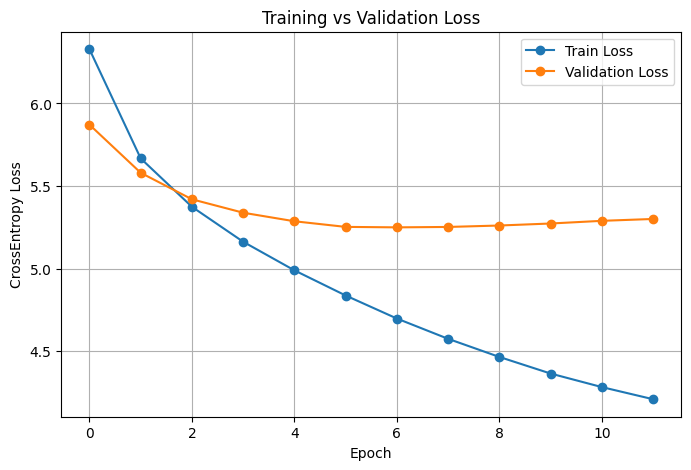


 Final Validation Loss: 5.3007
 Final Validation Accuracy: 19.49%


In [13]:
# TRAINING VS VALIDATION LOSS
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.legend()
plt.grid(True)
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

val_accuracy = 100 * correct / total
print(f"\n Final Validation Loss: {val_losses[-1]:.4f}")
print(f" Final Validation Accuracy: {val_accuracy:.2f}%")

In [14]:
embeddings = model.embedding.weight.detach().cpu().numpy()
print(embeddings.shape)


(16658, 64)


In [15]:
selected_words = [
    "good", "bad", "happy", "sad",              # antonyms
    "man", "woman",                             # gender relations
    "walk", "walking", "run", "running",        # verb forms
    "he", "she", "they", "him", "her", "them",  # pronouns
    "apple", "banana", "car", "road"            # unrelated
]


In [16]:
valid_words = [w for w in selected_words if w in word_to_idx]
indices = [word_to_idx[w] for w in valid_words]
print(valid_words)


['good', 'bad', 'happy', 'sad', 'man', 'woman', 'walk', 'walking', 'run', 'running', 'he', 'she', 'they', 'him', 'her', 'them', 'apple', 'banana', 'car', 'road']


In [17]:
word_vectors = embeddings[indices]


In [ ]:
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=1024, seq_len=5, dropout=0.3):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(embed_dim * seq_len, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim // 2, vocab_size)
        self.relu = nn.ReLU()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        embeds = self.embed_dropout(self.embedding(x))
        flat = embeds.view(embeds.size(0), -1)

        h = self.relu(self.fc1(flat))
        h = self.dropout(h)

        h = self.relu(self.fc2(h))
        h = self.dropout(h)

        out = self.fc_out(h)
        return out


In [19]:
from sklearn.manifold import TSNE


✅ Loaded mod_6_32_relu
✅ Loaded mod_12_32_relu
✅ Loaded mod_6_64_relu
✅ Loaded mod_12_64_relu
✅ Loaded mod_6_32_tanh
✅ Loaded mod_12_32_tanh
✅ Loaded mod_6_64_tanh
✅ Loaded mod_12_64_tanh


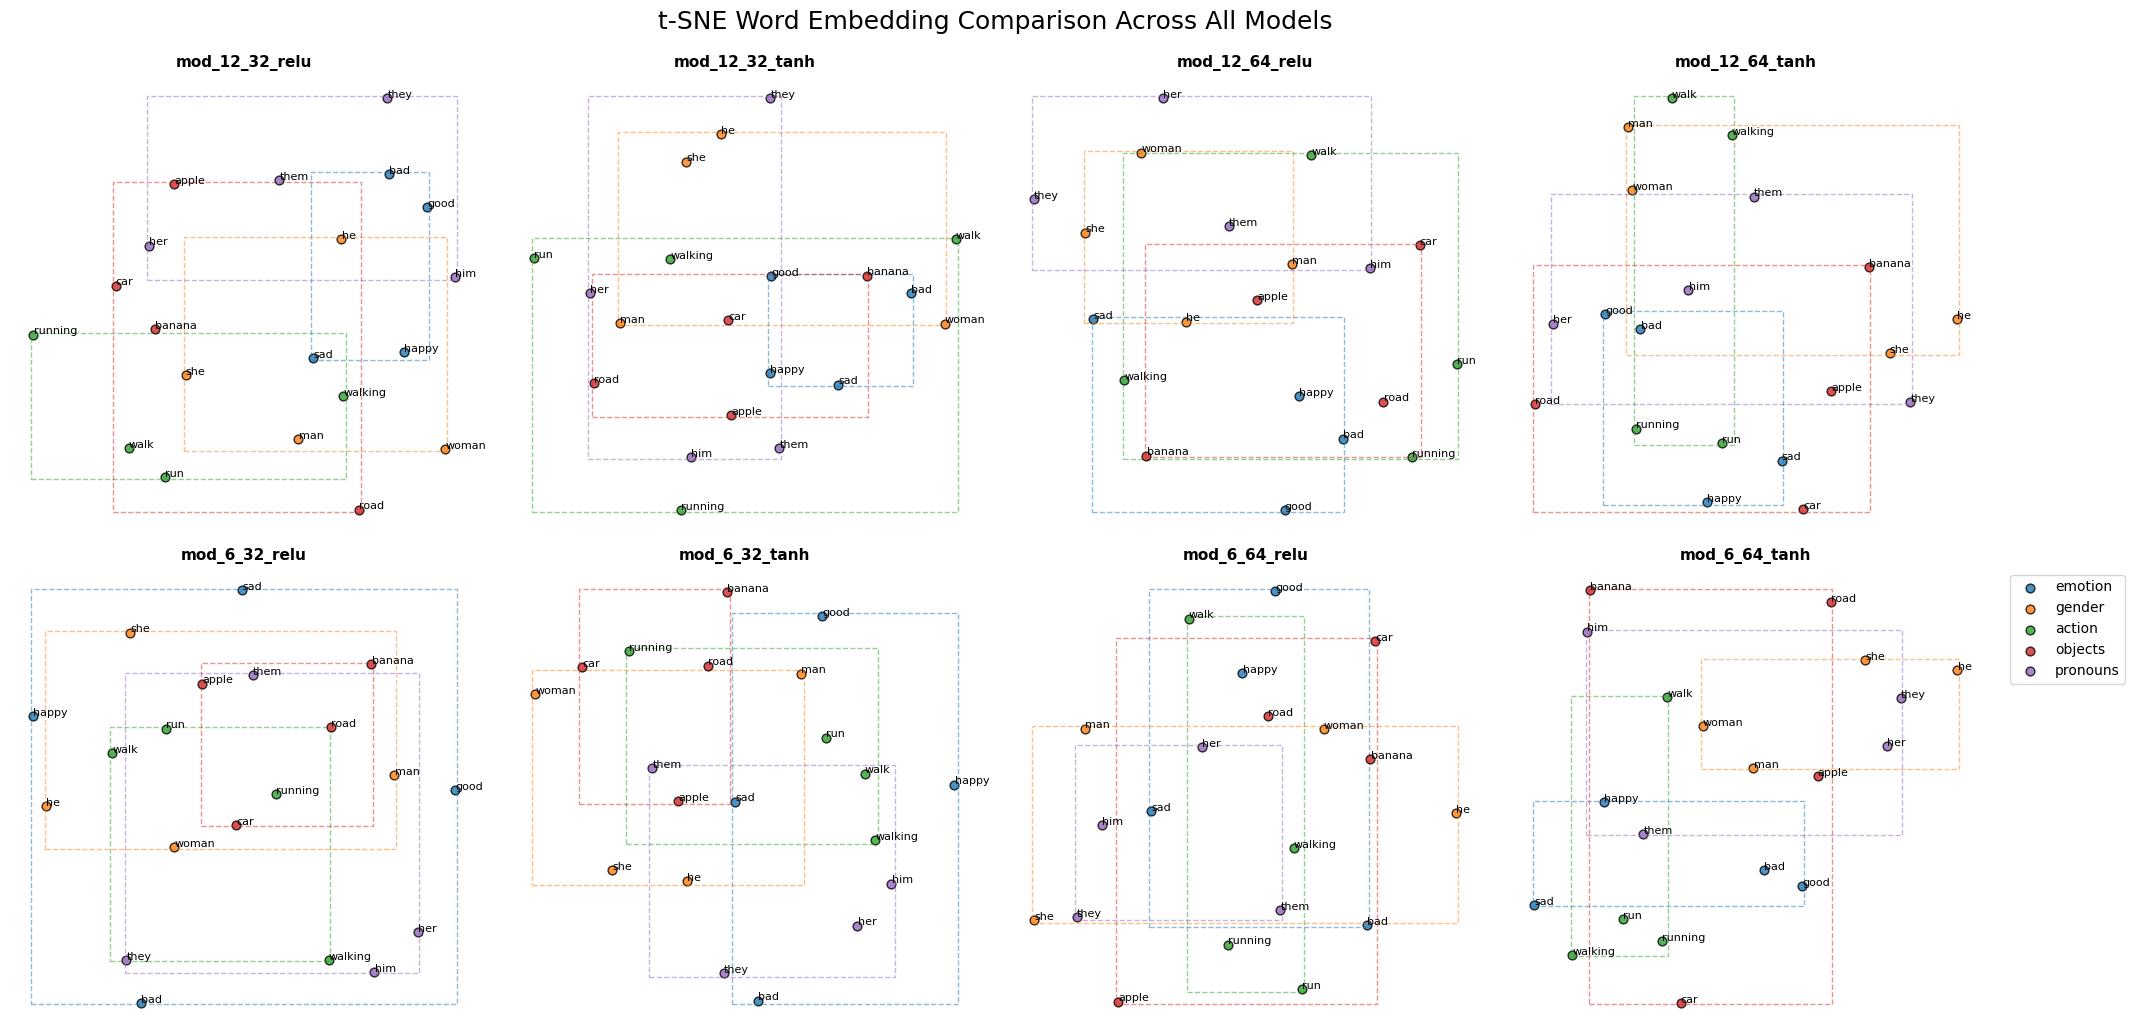

In [ ]:
import os
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# --- Model Definition ---
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=1024, seq_len=12, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(embed_dim * seq_len, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim // 2, vocab_size)
        self.relu = nn.ReLU()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

# --- Model Settings ---
embed_dims = [32, 64]
seq_lens = [6, 12]
activations = ["relu", "tanh"]

vocab_size = len(word_to_idx)
embeddings_dict = {}

# --- Load Models ---
for act in activations:
    for emb in embed_dims:
        for seq in seq_lens:
            name = f"mod_{seq}_{emb}_{act}"
            path = f"{name}.pth"
            if not os.path.exists(path):
                print(f"⚠️ Missing: {path}")
                continue
            try:
                model = MLPTextGenerator(vocab_size=vocab_size, embed_dim=emb, seq_len=seq)
                state = torch.load(path, map_location="cpu")
                model.load_state_dict({k: v for k, v in state.items() if "embedding" in k}, strict=False)
                model.eval()
                embeddings_dict[name] = model.embedding.weight.detach().cpu().numpy()
                print(f" Loaded {name}")
            except Exception as e:
                print(f" Error loading {name}: {e}")

# --- Semantic Groups & Colors ---
groups = {
    "emotion": (["good", "bad", "happy", "sad"], "tab:blue"),
    "gender": (["man", "woman", "he", "she"], "tab:orange"),
    "action": (["walk", "run", "walking", "running"], "tab:green"),
    "objects": (["car", "road", "apple", "banana"], "tab:red"),
    "pronouns": (["they", "them", "him", "her"], "tab:purple")
}

# Flatten all valid words
selected_words = sum([v[0] for v in groups.values()], [])
valid_words = [w for w in selected_words if w in word_to_idx]
indices = [word_to_idx[w] for w in valid_words]

# --- Plot ---
n = len(embeddings_dict)
rows, cols = 2, 4
plt.figure(figsize=(20, 10))

for i, (name, emb) in enumerate(sorted(embeddings_dict.items())):
    word_vectors = emb[indices]
    tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
    reduced = tsne.fit_transform(word_vectors)

    plt.subplot(rows, cols, i + 1)
    plt.title(name, fontsize=11, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.3)

    # Plot each group in a different color
    start = 0
    for label, (words, color) in groups.items():
        grp_indices = [valid_words.index(w) for w in words if w in valid_words]
        if not grp_indices:
            continue
        xs, ys = reduced[grp_indices, 0], reduced[grp_indices, 1]
        plt.scatter(xs, ys, label=label, color=color, s=40, alpha=0.8, edgecolors='k')
        for j, word in zip(grp_indices, words):
            plt.text(reduced[j, 0]+0.05, reduced[j, 1]+0.05, word, fontsize=8)

        # Add a boundary rectangle around each semantic group
        pad = 1.0
        rect = patches.Rectangle(
            (xs.min()-pad/2, ys.min()-pad/2),
            xs.max()-xs.min()+pad,
            ys.max()-ys.min()+pad,
            linewidth=1.0, edgecolor=color, facecolor='none', alpha=0.5, linestyle='--'
        )
        plt.gca().add_patch(rect)

    plt.axis("off")

plt.tight_layout()
plt.suptitle("t-SNE Word Embedding Comparison Across All Models", fontsize=18, y=1.03)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


###  t-SNE Word Embedding Comparison Across Models

#### **1. Effect of Sequence Length (6 vs 12)**
- **Longer context (seq_len = 12):**  
  Displays tighter and more coherent clusters.  
  Words such as *“man–woman”* and *“happy–sad”* are positioned closer, showing that the model captures semantic relationships effectively.  
  Longer context enables the network to learn **meaningful relational patterns** rather than just local word co-occurrences.

- **Shorter context (seq_len = 6):**  
  Embeddings appear scattered, and clusters overlap more.  
  Indicates that shorter context limits the model’s ability to understand longer-term dependencies.

**Conclusion:** Longer context leads to better sementic understanding.  


#### **2. Effect of Embedding Dimension (32 vs 64)**
- **Higher dimension (64):**    
  Words in similar categories (e.g., emotion or action) are more distinctly grouped.

- **Lower dimension (32):**  
  Some category overlap; embeddings compress multiple semantic axes together.

**Conclusion:** Increasing embedding dimension allows finer separation of semantics while trading more computational power.

---

#### **3. Effect of Activation Function (ReLU vs Tanh)**
- **Tanh:**  
  Similar-sentiment words (e.g., *“happy–good–smiling”*) cluster naturally.

- **ReLU:**  
  Generates sparser and more irregular clusters.  
  Some words are far apart than tanh.

 **Conclusion:** Tanh activations yield smoother and semantically meaningful spaces.  
 ReLU activations lead to more disjoint clusters.

